In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets
import torch.autograd as autograd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
data = pd.read_excel('/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/PINN/PINN_SIR_ex2.xlsx')
data

,time,cases
0,0,1
1,1,1
2,2,1
3,3,2
4,4,2
5,5,2
6,6,4
7,7,5
8,8,6
9,9,6


In [3]:
train_time = 20

x_train = torch.Tensor(data.loc[:train_time, 'time'].values).reshape(-1, 1).to(device)
y_train = torch.Tensor(data.loc[:train_time, 'cases'].values).reshape(-1, 1).to(device)

x_test = torch.Tensor(data.loc[train_time + 1:, 'time'].values).reshape(-1, 1).to(device)
y_test = torch.Tensor(data.loc[train_time + 1:, 'cases'].values).reshape(-1, 1).to(device)

In [4]:
# ODE parameters
N = 100
beta = 0.5
gamma = 1.0 / 4.0

#Initial condition
S0 = 99.0
I0 = 1.0
R0 = 0.0

#time domain
tl = 0
tr = 30

In [5]:
def deriv_SIR(u, N, beta, gamma):
  S = u[:,0:1]
  I = u[:,1:2]
  R = u[:, 2:3]
  dS = -beta * S * I / N
  dI = beta * S * I / N - gamma * I
  dR = gamma * I
  return torch.cat([dS, dI, dR], dim=1)

In [6]:
# Initial points
X_ic = torch.Tensor([0]).to(device)
U_ic = torch.Tensor([S0, I0, R0]).to(device)

In [7]:
from re import X
# Set the number of collocation points
N_colloc = 2000

# Collocation points
X_colloc = torch.rand(N_colloc, 1) * (tr - tl) + tl

# Store tensors to GPU
X_colloc = X_colloc.to(device)

In [8]:
class PINN_test(nn.Module):
  def __init__(self):
    super().__init__()

    self.tanh = nn.Tanh()

    self.l1 = nn.Linear(1, 50)
    self.l2 = nn.Linear(50, 50)
    self.l3 = nn.Linear(50, 50)
    self.l4 = nn.Linear(50, 3)

  def forward(self, x):
    x = self.l1(x)
    x = self.tanh(x)
    x = self.l2(x)
    x = self.tanh(x)
    x = self.l3(x)
    x = self.tanh(x)
    x = self.l4(x)
    return x

In [9]:
torch.cuda.manual_seed(123)
model_P = PINN_test().to(device)
optimizer_P = torch.optim.Adam(model_P.parameters(), lr=0.0005)

In [10]:
loss_train_P = []
loss_test_P = []

for epoch in range(20000):
  # 초기값에 대한 손실함수
  loss_BC = nn.MSELoss()(model_P(X_ic), U_ic)

  # 미분방정식에 대한 손실함수
  X_colloc.requires_grad = True
  f = model_P.forward(X_colloc)

  S_t = f[:,0:1]
  I_t = f[:,1:2]
  R_t = f[:,2:3]

  S_diff = autograd.grad(S_t, X_colloc, torch.ones([X_colloc.shape[0],1]).to(device),
                         retain_graph=True ,create_graph = True)[0]
  I_diff = autograd.grad(I_t, X_colloc, torch.ones([X_colloc.shape[0],1]).to(device),
                         retain_graph=True ,create_graph = True)[0]
  R_diff = autograd.grad(R_t, X_colloc, torch.ones([X_colloc.shape[0],1]).to(device),
                         retain_graph=True ,create_graph = True)[0]
  u_diff = torch.cat([S_diff, I_diff, R_diff], dim=1)

  ODE = deriv_SIR(u_diff, N, beta, gamma)
  loss_ODE = nn.MSELoss()(u_diff, deriv_SIR(f, N, beta, gamma))

  # 데이터에 대한 손실함수
  Data_f = model_P.forward(x_train)
  Data_I = Data_f[:,1:2]
  loss_Data = nn.MSELoss()(Data_I, y_train)

  loss = loss_BC + loss_ODE + loss_Data

  test_f = model_P.forward(x_test)
  test_I = test_f[:,1:2]

  loss_test = nn.MSELoss()(test_I, y_test)
  optimizer_P.zero_grad()
  loss.backward()
  optimizer_P.step()

  loss_train_P.append(loss.item())
  loss_test_P.append(loss_test.item())

  if epoch % 1000 == 0:
    print(f'epoch: {epoch}, loss: {loss.item()}, loss_valid: {loss_test.item()}')

epoch: 0, loss: 3368.50927734375, loss_valid: 99.6815185546875
epoch: 1000, loss: 1629.975341796875, loss_valid: 21.87717056274414
epoch: 2000, loss: 793.405029296875, loss_valid: 5.8178253173828125
epoch: 3000, loss: 316.7287902832031, loss_valid: 7.28912353515625
epoch: 4000, loss: 90.1034927368164, loss_valid: 8.03040599822998
epoch: 5000, loss: 14.581645965576172, loss_valid: 8.922207832336426
epoch: 6000, loss: 1.6328742504119873, loss_valid: 8.327192306518555
epoch: 7000, loss: 0.8982912302017212, loss_valid: 6.5715789794921875
epoch: 8000, loss: 0.7533648610115051, loss_valid: 6.644245147705078
epoch: 9000, loss: 0.579534113407135, loss_valid: 4.932412147521973
epoch: 10000, loss: 0.48856133222579956, loss_valid: 4.782060146331787
epoch: 11000, loss: 0.4541870355606079, loss_valid: 4.527371883392334
epoch: 12000, loss: 0.4352015554904938, loss_valid: 4.41907262802124
epoch: 13000, loss: 0.4275466203689575, loss_valid: 4.405660152435303
epoch: 14000, loss: 0.42075252532958984, lo

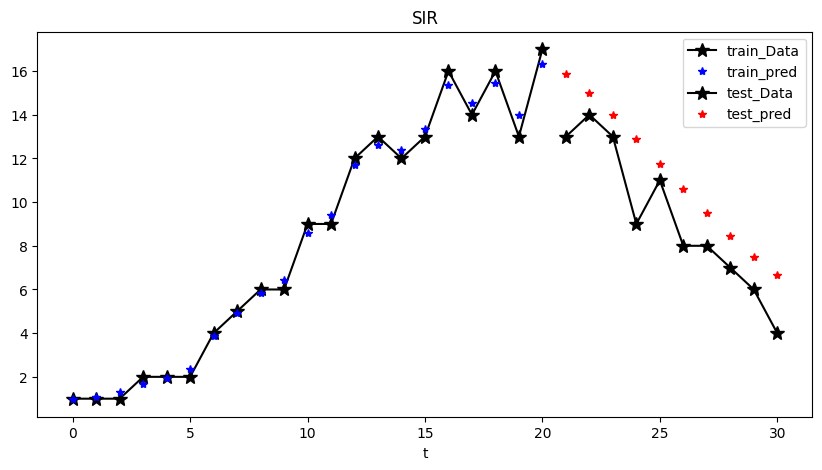

In [12]:
U_pred = model_P.forward(x_test)
with torch.no_grad():
  plt.figure(figsize = (10,5))
  plt.title("SIR")
  plt.plot(x_train.cpu(), y_train.cpu(), '-*k', markersize = 10, label = 'train_Data')
  plt.plot(x_train.cpu(), Data_I.cpu(), '*b', lw = 2, label = 'train_pred')
  plt.plot(x_test.cpu(), y_test.cpu(), '-*k', markersize = 10, label = 'test_Data')
  plt.plot(x_test.cpu(), U_pred.cpu()[:,1:2], '*r', lw = 2, label = 'test_pred')
  plt.legend()
  plt.xlabel('t')
  plt.show()

In [16]:
def deriv(u, N, beta, gamma):
  S, I, R = u
  dS = -beta * S * I / N
  dI = beta * S * I / N - gamma * I
  dR = gamma * I
  return np.array([dS, dI, dR])

In [14]:
def rk4(deriv, u0, t, N, beta, gamma):
  x = np.array((len(t))*[u0])
  h = t[1] - t[0]
  for i in range(len(t)-1):
    k1 = deriv(x[i], N, beta, gamma)
    k2 = deriv(x[i] + 0.5 * h * k1, N, beta, gamma)
    k3 = deriv(x[i] + 0.5 * h * k2, N, beta, gamma)
    k4 = deriv(x[i] + h * k3, N, beta, gamma)
    x[i+1] = x[i] + h * (k1 + 2*k2 + 2*k3 + k4) / 6
  return x

In [17]:
n = 750
t = np.linspace(tl, tr, n+1)
u0 = S0, I0, R0
u = rk4(deriv, u0, t, N, beta, gamma)

all_time_x_test = torch.Tensor(t).view(-1, 1).to(device)
all_time_U_test = torch.Tensor(u).to(device)

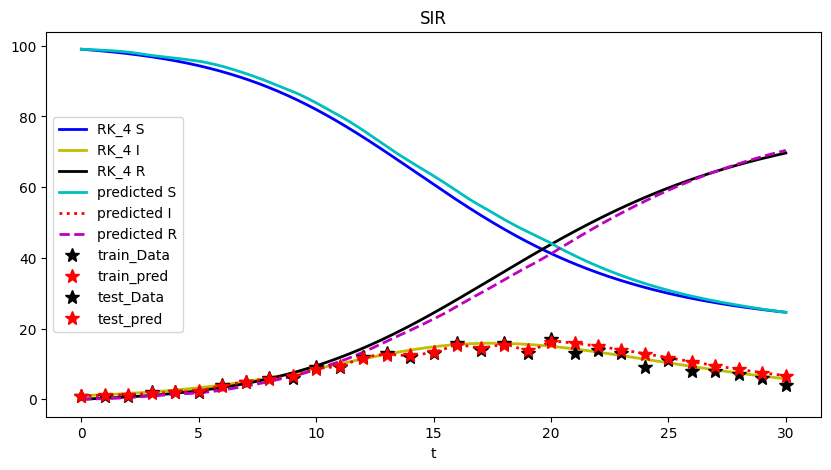

In [18]:
all_time_U_pred = model_P.forward(all_time_x_test)
with torch.no_grad():
  plt.figure(figsize = (10,5))
  plt.title("SIR")
  plt.plot(all_time_x_test.cpu(), all_time_U_test.cpu()[:,0:1],'b', lw = 2, label = 'RK_4 S')
  plt.plot(all_time_x_test.cpu(), all_time_U_test.cpu()[:,1:2],'y', lw = 2, label = 'RK_4 I')
  plt.plot(all_time_x_test.cpu(), all_time_U_test.cpu()[:,2:3],'k', lw = 2, label = 'RK_4 R')
  plt.plot(all_time_x_test.cpu(), all_time_U_pred.cpu()[:,0:1],'c-', lw = 2, label = 'predicted S')
  plt.plot(all_time_x_test.cpu(), all_time_U_pred.cpu()[:,1:2],'r:', lw = 2, label = 'predicted I')
  plt.plot(all_time_x_test.cpu(), all_time_U_pred.cpu()[:,2:3],'m--', lw = 2, label = 'predicted R')
  plt.plot(x_train.cpu(), y_train.cpu(), '*k', markersize = 10, label = 'train_Data')
  plt.plot(x_train.cpu(), Data_I.cpu(), '*r', markersize = 10, label = 'train_pred')
  plt.plot(x_test.cpu(), y_test.cpu(), '*k', markersize = 10, label = 'test_Data')
  plt.plot(x_test.cpu(), U_pred.cpu()[:,1:2], '*r', markersize = 10, label = 'test_pred')
  plt.legend()
  plt.xlabel('t')